In [2]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np
from tqdm.notebook import tqdm # Use notebook-friendly tqdm
import os

print("Libraries imported.")

Libraries imported.


In [3]:
# Cell 2: Define Constants and Paths
# We define all hyperparameters and paths manually
# to avoid importing from src/config.py

# Paths (relative to the 'notebooks' folder)
DATA_DIR = "../data/processed"
MODEL_DIR = "../models"
TRAIN_FILE = os.path.join(DATA_DIR, "training.pt")
TEST_FILE = os.path.join(DATA_DIR, "test.pt")
BASELINE_MODEL_PATH = os.path.join(MODEL_DIR, "cnn_classifier.pth")

# Ensure model directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 10
SEED = 42

print(f"Using device: {DEVICE}")
print(f"Model will be saved to: {BASELINE_MODEL_PATH}")
torch.manual_seed(SEED)

Using device: cuda
Model will be saved to: ../models\cnn_classifier.pth


In [4]:
# Cell 3: Define the BaseCNN Model
# We copy this class from src/model_zoo.py
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

print("BaseCNN class defined.")

BaseCNN class defined.


In [5]:
# Cell 4: Load Data
def load_data(train_file, test_file, batch_size):
    print(f"Loading processed data...")
    try:
        train_images, train_labels = torch.load(train_file)
        test_images, test_labels = torch.load(test_file)
    except FileNotFoundError:
        print("---!!! ERROR: Processed data not found! !!!---")
        print("Please go to your terminal and run your 'datautils.py' script first.")
        return None, None
    
    train_ds = TensorDataset(train_images, train_labels)
    test_ds = TensorDataset(test_images, test_labels)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader = load_data(TRAIN_FILE, TEST_FILE, BATCH_SIZE)

Loading processed data...


In [6]:
# Cell 5: Initialize Model, Loss, and Optimizer
if train_loader:
    model = BaseCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("Model, Criterion, and Optimizer initialized.")
else:
    print("Skipping training due to data loading error.")

Model, Criterion, and Optimizer initialized.


In [7]:
# Cell 6: Training Loop (Modified to store history)
if train_loader:
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }
    
    best_test_acc = 0.0
    print("Starting training...")

    for epoch in range(EPOCHS):
        # --- Training ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
        
        for inputs, labels in pbar_train:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar_train.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100.*correct/total:.2f}%")
            
        history['train_loss'].append(running_loss / len(train_loader))
        history['train_acc'].append(100. * correct / total)

        # --- Evaluation ---
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        pbar_test = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Test]")
        
        with torch.no_grad():
            for inputs, labels in pbar_test:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_test.set_postfix(acc=f"{100.*correct/total:.2f}%")

        test_acc = 100. * correct / total
        history['test_loss'].append(running_loss / len(test_loader))
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1} | Train Acc: {history['train_acc'][-1]:.2f}% | Test Acc: {test_acc:.2f}%")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            print(f"  -> New best test accuracy. Saving model to {BASELINE_MODEL_PATH}")
            torch.save(model.state_dict(), BASELINE_MODEL_PATH)

    print("\nTraining complete.")
    print(f"Best test accuracy: {best_test_acc:.2f}%")

Starting training...


Epoch 1/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 | Train Acc: 95.37% | Test Acc: 98.45%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 2/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 | Train Acc: 98.43% | Test Acc: 98.70%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 3/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 | Train Acc: 98.84% | Test Acc: 98.89%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 4/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 | Train Acc: 99.04% | Test Acc: 98.93%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 5/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 | Train Acc: 99.25% | Test Acc: 99.05%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 6/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6 | Train Acc: 99.39% | Test Acc: 99.20%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 7/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7 | Train Acc: 99.44% | Test Acc: 99.24%
  -> New best test accuracy. Saving model to ../models\cnn_classifier.pth


Epoch 8/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8 | Train Acc: 99.54% | Test Acc: 99.14%


Epoch 9/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9 | Train Acc: 99.58% | Test Acc: 99.23%


Epoch 10/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10 | Train Acc: 99.60% | Test Acc: 99.24%

Training complete.
Best test accuracy: 99.24%


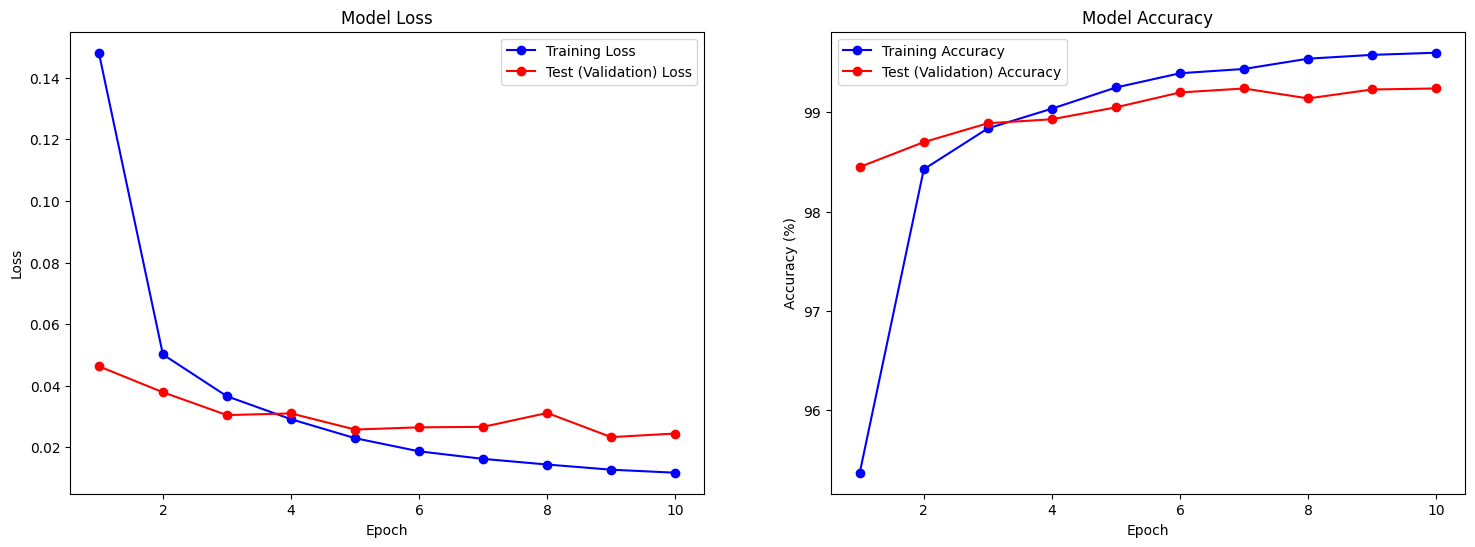

In [8]:
# Cell 7: Plot Training & Validation Curves
if train_loader:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    epochs_range = range(1, EPOCHS + 1)

    # Plot Loss
    ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss')
    ax1.plot(epochs_range, history['test_loss'], 'r-o', label='Test (Validation) Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy')
    ax2.plot(epochs_range, history['test_acc'], 'r-o', label='Test (Validation) Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

Plotting Confusion Matrix...


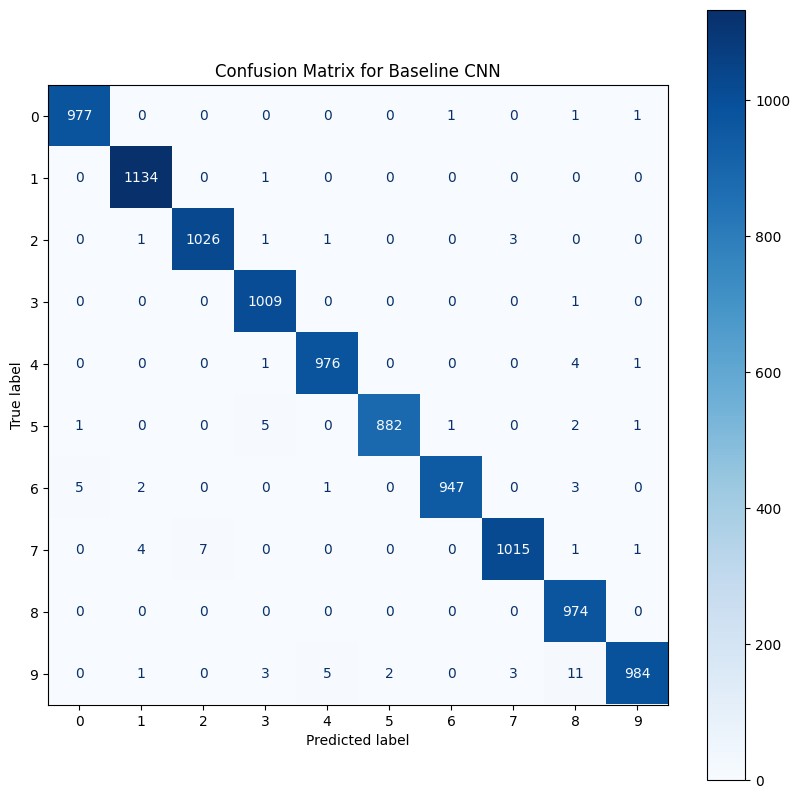


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [9]:
# Cell 8: Generate and Plot Confusion Matrix
if train_loader:
    # Load the *best* model we just saved
    model.load_state_dict(torch.load(BASELINE_MODEL_PATH))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot Confusion Matrix
    print("Plotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix for Baseline CNN')
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))